In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
import Util
import linear_shrinkage

In [2]:
ret, ret_nonan, univ, tradeidx, dates = Util.load_data()

In [3]:
#Sanity check with Michael's code
today = tradeidx[0][0]
pastData = Util.get_past_period(h=0, T = 1260, N = 200, univ = univ, tradeidx = tradeidx, ret = ret)
investData = Util.get_invest_period(h=0, P = 1, N = 200, univ = univ, tradeidx = tradeidx, ret = ret)
combinedData = np.concatenate((pastData, investData))
print(combinedData.min())
print(combinedData.max())
print(combinedData.mean())

-0.31855
0.23618000000000003
0.0008989193208430914


In [4]:
def get_OOS_rets(cov_estimator, N, T, P, ret, univ, tradeidx, range_h = None, past_ret_passed = True):   
    if not range_h:
        range_h = len(univ)
    rets = []
    
    #MTP2_cov_est = Util.MTP2_cov(N,T)

    for h in range(range_h):
        pastRet = Util.get_past_period(h, T, N, univ, tradeidx, ret)
        if past_ret_passed:
            cov = cov_estimator(pastRet)
        else:
            cov = cov_estimator(h)
        w = Util.optimal_weights(cov)
        outRet = Util.get_invest_period(h, P, N, univ, tradeidx, ret)
        curret = Util.OOS_rets(outRet, w)
        rets.append(curret)
    return rets

In [24]:
N = 200
#T = 1260
T = 100
P = 1

In [25]:
MTP2_rets = get_OOS_rets(Util.MTP2_cov(N, T), 
                         N, T, P, 
                         ret, univ, tradeidx,
                         range_h = None, past_ret_passed = False)

In [32]:
Util.print_normalize(MTP2_rets)

0.10356935273133408 0.12156485667207856


In [26]:
equal_rets = get_OOS_rets(Util.identity_cov, 
                          N, T, P,
                          ret, univ, tradeidx,
                          range_h = None)

In [8]:
Util.print_normalize(equal_rets)

0.12918692971707574 0.18754260906922615


In [27]:
linear_shrinkage_rets = get_OOS_rets(linear_shrinkage.estimator, 
                                     N, T, P,
                                     ret, univ, tradeidx,
                                     range_h = None)

In [10]:
Util.print_normalize(linear_shrinkage_rets)

0.1111813838931928 0.12025630116520909


In [13]:
def cum_var(rets):
    vs = []
    for i in range(1, len(rets)):
        vs.append(np.var(rets[:i]))
    return vs

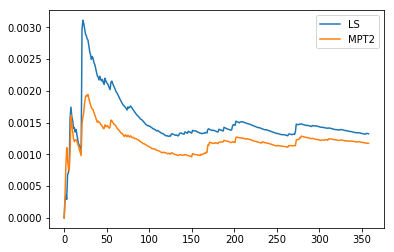

In [28]:
#plt.plot(cum_var(equal_rets), label = 'eq')
plt.plot(cum_var(linear_shrinkage_rets), label = 'LS')
plt.plot(cum_var(MTP2_rets), label = 'MPT2')
plt.legend()
plt.show()

0.18725603933580148
0.13055448598879457
0.12003289206403091


(array([1., 2., 8., 7., 5., 9., 5., 3., 3., 7.]),
 array([0.0995976 , 0.10339678, 0.10719597, 0.11099515, 0.11479433,
        0.11859351, 0.12239269, 0.12619188, 0.12999106, 0.13379024,
        0.13758942]),
 <a list of 10 Patch objects>)

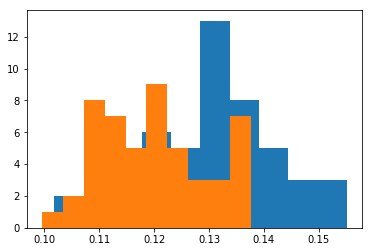

In [34]:
equal_stds = Util.subsample(equal_rets)
print(np.mean(equal_stds))
shrinkage_stds = Util.subsample(linear_shrinkage_rets)
print(np.mean(shrinkage_stds))
MTP2_stds = Util.subsample(MTP2_rets)
print(np.mean(MTP2_stds))
#plt.hist(equal_stds)
plt.hist(shrinkage_stds)
plt.hist(MTP2_stds)

In [86]:
iden_shrink = {}
for lamb in [0.02, 0.01, 0.005, 0.001, 0.0001, 0.00001]:
    identity_shrinkage_rets = get_OOS_rets(linear_shrinkage.lambda_identity(lamb), 
                                     N, T, P,
                                     ret, univ, tradeidx,
                                     range_h = None)
    iden_shrink[lamb] = identity_shrinkage_rets
    print("Hat(S) = lamb * I + (1-lamb) * S. lamb = {}".format(lamb))
    Util.print_normalize(identity_shrinkage_rets)

Hat(S) = lamb * I + (1-lamb) * S. lamb = 0.02
0.12889356190921292 0.16086244248396164
Hat(S) = lamb * I + (1-lamb) * S. lamb = 0.01
0.1271406113860214 0.1502553276012488
Hat(S) = lamb * I + (1-lamb) * S. lamb = 0.005
0.12470699440534072 0.14019147442546426
Hat(S) = lamb * I + (1-lamb) * S. lamb = 0.001
0.11821106953523904 0.12446987474162771
Hat(S) = lamb * I + (1-lamb) * S. lamb = 0.0001
0.11348993246735943 0.11832584332613025
Hat(S) = lamb * I + (1-lamb) * S. lamb = 1e-05
0.11157276239004392 0.12053805332176938
